In [ ]:
# from tdc.multi_pred import DTI
# import pandas as pd
# import numpy as np
# from rdkit import Chem
# from rdkit.Chem import AllChem
# from transformers import BertTokenizer, BertModel
# import torch

In [ ]:
data = DTI(name = 'BindingDB_Kd')
data.harmonize_affinities(mode = 'max_affinity')
# data.harmonize_affinities(mode = 'mean')

Found local copy...
Loading...
Done!
The scale is in original affinity scale, so we will take the minimum!
The original data has been updated!


,Drug_ID,Drug,Target_ID,Target,Y
0,51.0,O=C(O)CCC(=O)C(=O)O,Q9GZT9,MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEH...,900.0
1,187.0,CC(=O)OCC[N+](C)(C)C,P11229,MNTSAPPAVSPNITVLAPGKGPWQVAFIGITTGLLSLATVTGNLLV...,17378.0
2,187.0,CC(=O)OCC[N+](C)(C)C,P58154,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,458.0
3,237.0,CCN(CC)CCCC(C)Nc1c2ccc(Cl)cc2nc2ccc(OC)cc12,P02752,MLRFAITLFAVITSSTCQQYGCLEGDTHKANPSPEPNMHECTLYSE...,264.0
4,242.0,O=C([O-])c1ccccc1,P14920,MRVVVIGAGVIGLSTALCIHERYHSVLQPLDIKVYADRFTPLTTTD...,2200.0
...,...,...,...,...,...
42231,138805907.0,COc1nc2ccc([C@@](O)(c3ccc(C(F)(F)F)nc3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.1
42232,138805908.0,COc1nc2ccc([C@](O)(c3ccnc(C(F)(F)F)c3)c3cncn3C...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,9300.0
42233,138805909.0,COc1nc2ccc([C@@](O)(c3ccnc(C(F)(F)F)c3)c3cncn3...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,3.5
42234,138805910.0,COc1nc2ccc([C@](O)(c3ccc(Cl)cc3)c3cncn3C)cc2c(...,P51449,MDRAPQRQHRASRELLAAKKTHTSQIEVIPCKICGDKSSGIHYGVI...,850.0


In [3]:
bindDB = data.get_data()

In [4]:
split = data.get_split()

In [5]:
split.keys()

dict_keys(['train', 'valid', 'test'])

In [54]:
split = data.get_split()
train_data = split['train']
valid_data = split['valid']
test_data = split['test']

In [55]:
train_data.head()

,Drug_ID,Drug,Target_ID,Target,Y
0,51.0,O=C(O)CCC(=O)C(=O)O,Q9GZT9,MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEH...,900.0
1,187.0,CC(=O)OCC[N+](C)(C)C,P58154,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,458.0
2,264.0,CCCC(=O)O,Q9Z429,MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...,92000.0
3,311.0,O=C(O)CC(O)(CC(=O)O)C(=O)O,P15474,MPRSLANAPIMILNGPNLNLLGQRQPEIYGSDTLADVEALCVKAAA...,7300.0
4,525.0,O=C(O)CC(O)C(=O)O,Q9Z429,MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...,8500.0


In [56]:
import numpy as np

# Log-transform affinities
train_data["Affinity"] = -np.log10(train_data["Y"] + 1e-9)
valid_data["Affinity"] = -np.log10(valid_data["Y"] + 1e-9)
test_data["Affinity"] = -np.log10(test_data["Y"] + 1e-9)

# Extract labels
train_labels = train_data["Affinity"].values
valid_labels = valid_data["Affinity"].values
test_labels = test_data["Affinity"].values


In [57]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemRoBERTa tokenizer and model
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Load ESM2 tokenizer and model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
def extract_chem_features(smiles):
    """Extract ChemRoBERTa features from SMILES."""
    try:
        tokens = chem_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = chem_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

def extract_esm_features(sequence):
    """Extract ESM2 features from protein sequence."""
    try:
        tokens = esm_tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = esm_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

In [59]:
# Function to featurize drug SMILES into molecular fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    else:
        return np.zeros(2048)

# Load ProtBERT for protein embedding
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertModel.from_pretrained("Rostlab/prot_bert")

# Function to featurize protein sequences
def featurize_protein(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [60]:
# Featurize drugs
train_data["Drug_Features"] = train_data["Drug"].apply(extract_chem_features)
valid_data["Drug_Features"] = valid_data["Drug"].apply(extract_chem_features)
test_data["Drug_Features"] = test_data["Drug"].apply(extract_chem_features)

In [61]:
# Featurize proteins
train_data["Target_Features"] = train_data["Target"].apply(extract_esm_features)
valid_data["Target_Features"] = valid_data["Target"].apply(extract_esm_features)
test_data["Target_Features"] = test_data["Target"].apply(extract_esm_features)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [63]:
torch.save(train_data, 'train_data.pt')
torch.save(valid_data, 'valid_data.pt')
torch.save(test_data, 'test_data.pt')

In [3]:
train_data_torch = torch.load('../BindDBdata/train_data.pt')
valid_data_torch = torch.load('../BindDBdata/valid_data.pt')
test_data_torch = torch.load('../BindDBdata/test_data.pt')

In [9]:
train_data_torch.head()

,Drug_ID,Drug,Target_ID,Target,Y,Affinity,Drug_Features,Target_Features
0,51.0,O=C(O)CCC(=O)C(=O)O,Q9GZT9,MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEH...,900.0,-2.954243,"[0.05922501, -0.1811509, -0.16278866, -0.68591...","[0.04429893, -0.23408644, -0.025642965, 0.2387..."
1,187.0,CC(=O)OCC[N+](C)(C)C,P58154,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,458.0,-2.660865,"[0.75248355, 0.35702756, 0.19409956, -0.576057...","[-0.08967179, -0.03742869, 0.18693264, 0.00136..."
2,264.0,CCCC(=O)O,Q9Z429,MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...,92000.0,-4.963788,"[0.32803044, 0.5135764, -0.6358537, -1.4450827...","[-0.13713697, 0.12942791, 0.05652572, -0.11863..."
3,311.0,O=C(O)CC(O)(CC(=O)O)C(=O)O,P15474,MPRSLANAPIMILNGPNLNLLGQRQPEIYGSDTLADVEALCVKAAA...,7300.0,-3.863323,"[-0.028915664, 0.14051561, -0.24122387, -0.677...","[-0.053845033, -0.0786545, 0.098353215, -0.090..."
4,525.0,O=C(O)CC(O)C(=O)O,Q9Z429,MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...,8500.0,-3.929419,"[0.18948534, 0.033285465, 0.09464533, -0.81195...","[-0.13713697, 0.12942791, 0.05652572, -0.11863..."


In [25]:
import numpy as np

# Log-transform affinities
train_data_torch["Affinity"] = -np.log10(train_data_torch["Y"] + 1e-9)
valid_data_torch["Affinity"] = -np.log10(valid_data_torch["Y"] + 1e-9)
test_data_torch["Affinity"] = -np.log10(test_data_torch["Y"] + 1e-9)

# Extract labels
train_labels = train_data_torch["Affinity"].values
valid_labels = valid_data_torch["Affinity"].values
test_labels = test_data_torch["Affinity"].values

In [26]:
# Combine drug and target features
train_features = np.stack([
    np.concatenate([row.Drug_Features, row.Target_Features]) for _, row in train_data_torch.iterrows()
])
valid_features = np.stack([
    np.concatenate([row.Drug_Features, row.Target_Features]) for _, row in valid_data_torch.iterrows()
])
test_features = np.stack([
    np.concatenate([row.Drug_Features, row.Target_Features]) for _, row in test_data_torch.iterrows()
])

In [27]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim import Adam

In [28]:
# Convert datasets to PyTorch DataLoader
train_dataset = TensorDataset(
    torch.tensor(train_features, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.float32)
)
valid_dataset = TensorDataset(
    torch.tensor(valid_features, dtype=torch.float32),
    torch.tensor(valid_labels, dtype=torch.float32)
)

In [29]:
import torch.nn as nn
import torch

class DDPM(nn.Module):
    def __init__(self, input_dim, time_steps):
        super(DDPM, self).__init__()
        self.time_steps = time_steps
        self.embed = nn.Linear(input_dim, 128)  # Embed the input to a smaller dimension
        self.noise_predictor = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.output_layer = nn.Linear(128, 1)  # Continuous regression output

    def forward_diffusion(self, x, t):
        noise = torch.randn_like(x)  # Noise has the same shape as x
        t = t.view(-1, 1).expand_as(x)  # Expand t to match x's shape
        alpha_t = torch.exp(-0.1 * t.float())  # Compute alpha_t
        noisy_x = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise
        return noisy_x, noise

    def reverse_denoising(self, noisy_x, t):
        x = self.embed(noisy_x)  # Reduce dimensionality
        x = self.noise_predictor(x)  # Predict and process noise
        return x

    def forward(self, x, t):
        noisy_x, noise = self.forward_diffusion(x, t)
        denoised_x = self.reverse_denoising(noisy_x, t)
        binding_affinity = self.output_layer(denoised_x)
        return binding_affinity, noise



In [30]:
import csv

# Initialize log file
log_file = "training_metrics.csv"
with open(log_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train_Loss", "Valid_RMSE", "Valid_MAE", "Valid_R2"])

In [31]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Initialize model, optimizer, and loss function
model = DDPM(input_dim=train_features.shape[1], time_steps=100)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    for features, labels in train_loader:
        t = torch.randint(0, model.time_steps, (features.shape[0],))  # Random time steps
        optimizer.zero_grad()
        pred_affinities, _ = model(features, t)
        loss = criterion(pred_affinities.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    valid_predictions, valid_labels_list = [], []
    with torch.no_grad():
        for features, labels in valid_loader:
            t = torch.zeros(features.shape[0])  # Use t=0 for prediction
            preds, _ = model(features, t)
            valid_predictions.extend(preds.squeeze().cpu().numpy())
            valid_labels_list.extend(labels.cpu().numpy())

    # Compute validation metrics
    valid_rmse = mean_squared_error(valid_labels_list, valid_predictions, squared=False)
    valid_mae = mean_absolute_error(valid_labels_list, valid_predictions)
    valid_r2 = r2_score(valid_labels_list, valid_predictions)

    # Log metrics to CSV
    with open(log_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, train_loss / len(train_loader), valid_rmse, valid_mae, valid_r2])

    # Print progress
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"  Valid RMSE: {valid_rmse:.4f}, Valid MAE: {valid_mae:.4f}, Valid R2: {valid_r2:.4f}")

Epoch 1/1000
  Train Loss: 2.9982
  Valid RMSE: 1.3528, Valid MAE: 1.0830, Valid R2: 0.0197
Epoch 2/1000
  Train Loss: 1.9517
  Valid RMSE: 1.3276, Valid MAE: 0.9721, Valid R2: 0.0559
Epoch 3/1000
  Train Loss: 1.9475
  Valid RMSE: 1.3167, Valid MAE: 1.0206, Valid R2: 0.0714
Epoch 4/1000
  Train Loss: 1.9298
  Valid RMSE: 1.3271, Valid MAE: 0.9471, Valid R2: 0.0565
Epoch 5/1000
  Train Loss: 1.9297
  Valid RMSE: 1.3048, Valid MAE: 0.9447, Valid R2: 0.0880
Epoch 6/1000
  Train Loss: 1.9333
  Valid RMSE: 1.3003, Valid MAE: 0.9972, Valid R2: 0.0943
Epoch 7/1000
  Train Loss: 1.9392
  Valid RMSE: 1.2877, Valid MAE: 0.9683, Valid R2: 0.1118
Epoch 8/1000
  Train Loss: 1.9272
  Valid RMSE: 1.2868, Valid MAE: 0.9683, Valid R2: 0.1130
Epoch 9/1000
  Train Loss: 1.9214
  Valid RMSE: 1.2860, Valid MAE: 1.0046, Valid R2: 0.1141
Epoch 10/1000
  Train Loss: 1.9194
  Valid RMSE: 1.2825, Valid MAE: 0.9892, Valid R2: 0.1189
Epoch 11/1000
  Train Loss: 1.9192
  Valid RMSE: 1.2845, Valid MAE: 1.0139, Val

In [32]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert the test features and labels into PyTorch tensors
test_dataset = TensorDataset(
    torch.tensor(test_features, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.float32)
)

# Create DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [33]:
# Test evaluation
model.eval()
test_predictions, test_labels_list = [], []

with torch.no_grad():
    for features, labels in DataLoader(test_dataset, batch_size=64, shuffle=False):
        t = torch.zeros(features.shape[0])  # Use t=0 for prediction
        preds, _ = model(features, t)
        test_predictions.extend(preds.squeeze().cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Compute test metrics
test_rmse = mean_squared_error(test_labels_list, test_predictions, squared=False)
test_mae = mean_absolute_error(test_labels_list, test_predictions)
test_r2 = r2_score(test_labels_list, test_predictions)

# Log test metrics to CSV
with open(log_file, mode="a", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Test", "-", test_rmse, test_mae, test_r2])

# Print test metrics
print("Test Results:")
print(f"  Test RMSE: {test_rmse:.4f}")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Test R2: {test_r2:.4f}")

Test Results:
  Test RMSE: 1.1425
  Test MAE: 0.7648
  Test R2: 0.3060


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

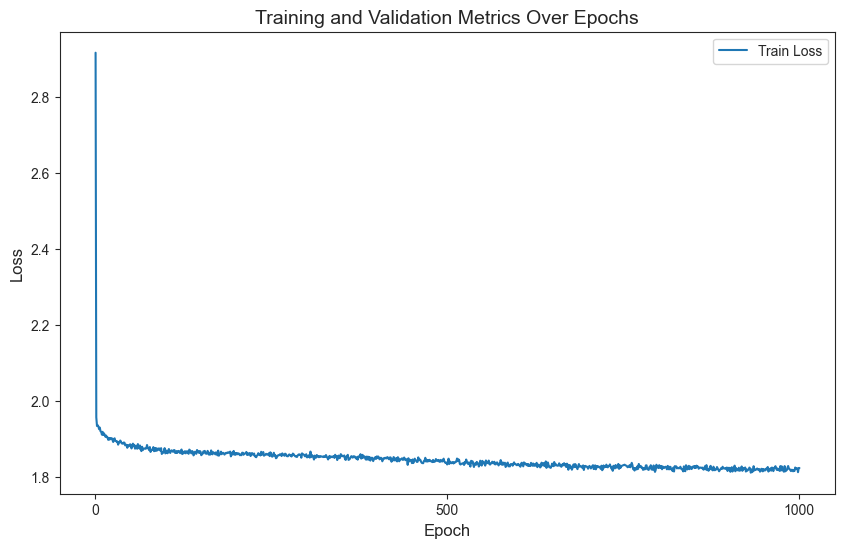

In [78]:
# Load metrics

metrics = pd.read_csv(log_file)
metrics = metrics.iloc[:-1]

metrics[['Epoch','Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']] = metrics[['Epoch', 'Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics, x='Epoch', y='Train_Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()

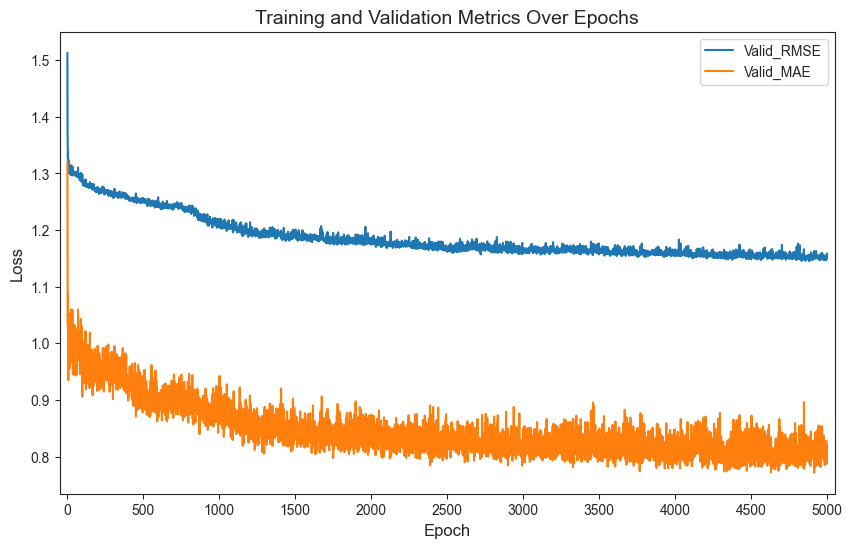

In [ ]:
# Load metrics

metrics = pd.read_csv(log_file)
metrics = metrics.iloc[:-1]

metrics[['Epoch','Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']] = metrics[['Epoch', 'Train_Loss', 'Valid_RMSE', 'Valid_MAE', 'Valid_R2']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='Epoch', y='Train_Loss', label='Train Loss')
sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()

